In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import noisereduce as nr
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import jiwer  
import time

import pywt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

c:\Users\gabry\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preparation

## Loading Data

In [2]:
# Konfigurasi
TRAINING = "augdata2/training"
VALIDATION = "augdata2/validation"
COMMANDS = ["baca", "berhenti", "foto", "halo", "info", "kembali", "ulang"]

In [3]:
# Load data training
Xt = []
yt = []

for label in COMMANDS:
    folder_path = os.path.join(TRAINING, label)
    for filename in os.listdir(folder_path):
        if filename.endswith(".wav"):
            file_path = os.path.join(folder_path, filename)
            Xt.append(file_path)
            yt.append(label)

Xt = np.array(Xt)  
yt = np.array(yt)

In [4]:
len(Xt)

7098

In [5]:
# Buat dataframe
df_train = pd.DataFrame()
df_train['speech'] = Xt 
df_train['label'] = yt

df_train.head()

,speech,label
0,augdata2/training\baca\baca102_dyn.wav,baca
1,augdata2/training\baca\baca102_noise.wav,baca
2,augdata2/training\baca\baca102_original.wav,baca
3,augdata2/training\baca\baca102_pitch.wav,baca
4,augdata2/training\baca\baca102_shift.wav,baca


In [6]:

df_train['label'].value_counts()

label
kembali     1029
baca        1015
berhenti    1015
foto        1015
ulang       1015
info        1008
halo        1001
Name: count, dtype: int64

In [7]:
# Load data validaion
Xv = []
yv = []

for label in COMMANDS:
    folder_path = os.path.join(VALIDATION, label)
    for filename in os.listdir(folder_path):
        if filename.endswith(".wav"):
            file_path = os.path.join(folder_path, filename)
            Xv.append(file_path)
            yv.append(label)

Xv = np.array(Xv)  
yv = np.array(yv)

# Buat dataframe
df_valid = pd.DataFrame()
df_valid['speech'] = Xv
df_valid['label'] = yv

df_valid.head()

,speech,label
0,augdata2/validation\baca\baca100_original.wav,baca
1,augdata2/validation\baca\baca101_original.wav,baca
2,augdata2/validation\baca\baca103_original.wav,baca
3,augdata2/validation\baca\baca104_original.wav,baca
4,augdata2/validation\baca\baca105_original.wav,baca


In [8]:
df_valid['label'].value_counts()

label
kembali     221
foto        219
baca        218
berhenti    218
ulang       218
info        217
halo        216
Name: count, dtype: int64

In [9]:
len(Xv)

1527

In [10]:
# Tahapan Preprocessing

def load_audio(file_path, sr=16000):
    audio, sample_rate = librosa.load(file_path, sr=sr)
    return audio / np.max(np.abs(audio)), sample_rate 

In [11]:
# Dapatkan jumlah core
num_cores = multiprocessing.cpu_count()

# Jalankan preprocessing
results = Parallel(n_jobs=num_cores)(
    delayed(load_audio)(file_path)
    for file_path in df_train['speech']
)

In [12]:
# Dapatkan jumlah core
num_cores = multiprocessing.cpu_count()

# Jalankan preprocessing
results = Parallel(n_jobs=num_cores)(
    delayed(load_audio)(file_path)
    for file_path in df_valid['speech']
)

## EDA

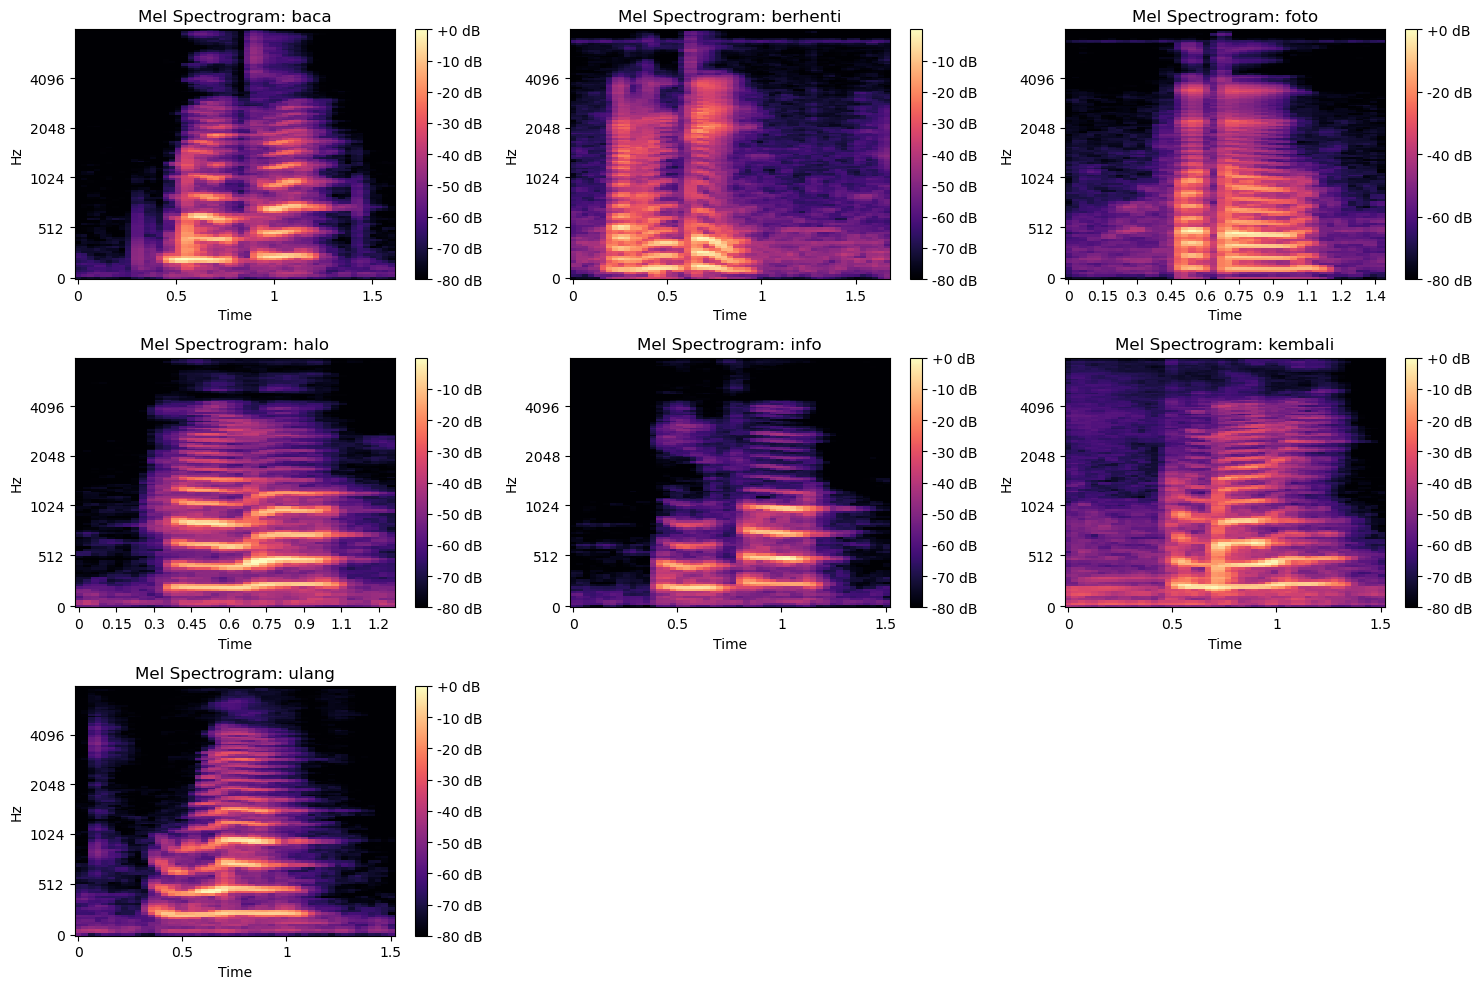

In [13]:
# Visualisasi spectrogram per label
def visualize_per_label(df_train):
    labels = df_train['label'].unique()

    plt.figure(figsize=(15, 10))

    for i, label in enumerate(labels):
        example_path = df_train[df_train['label'] == label]['speech'].values[0]

        # Preprocessing
        audio, sr = load_audio(example_path)

        # Menghitung Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)

        # Plot
        plt.subplot(3, 3, i + 1)
        librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max),
                                 sr=sr, x_axis='time', y_axis='mel')
        plt.title(f'Mel Spectrogram: {label}')
        plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

# Panggil fungsi visualisasi
visualize_per_label(df_train)

## MFCC

In [14]:
# def extract_mfcc(audio, sample_rate, n_mfcc=13):
#     """Extract MFCC features from audio"""
#     mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
#     return mfcc.T  # shape: (time_steps, n_mfcc)

# def full_mfcc_pipeline(file_path):
#     """Full processing pipeline for a single audio file"""
#     audio, sr = load_audio(file_path)
#     return extract_mfcc(audio, sr)

# def parallel_mfcc_extraction(file_paths, n_jobs=-1):
#     return Parallel(n_jobs=n_jobs)(
#         delayed(full_mfcc_pipeline)(file_path)
#         for file_path in tqdm(file_paths, desc="Extracting MFCC features")
#     )

# # Usage
# dfn['mfcc'] = parallel_mfcc_extraction(dfn['speech'].values)
# dfn.head()


# Parameter
SAMPLE_RATE = 16000
N_MFCC = 13
N_MELS = 22
WINDOW = int(SAMPLE_RATE * 0.01)
HOP = int(SAMPLE_RATE * 0.005)

# Load dan proses WPD
def load_audio(fp): return librosa.load(fp, sr=SAMPLE_RATE)[0]
def wpd(signal): 
    wp = pywt.WaveletPacket(signal, wavelet='db4', mode='symmetric', maxlevel=3)
    return np.concatenate([n.data for n in wp.get_level(3, 'freq')])

# Ekstrak MFCC dari sinyal hasil WPD
def extract_mfcc(signal): 
    return librosa.feature.mfcc(y=wpd(signal), sr=SAMPLE_RATE, n_mfcc=N_MFCC, 
                                n_mels=N_MELS, n_fft=WINDOW, hop_length=HOP).T

# Proses paralel
def process_all(paths): 
    return Parallel(n_jobs=-1)(delayed(lambda p: extract_mfcc(load_audio(p)))(p) 
                               for p in tqdm(paths, desc="Extracting MFCC"))

# Pemakaian
df_train['mfcc'] = process_all(df_train['speech'].values)
df_valid['mfcc'] = process_all(df_valid['speech'].values)

Extracting MFCC: 100%|██████████| 1527/1527 [00:00<00:00, 1829.04it/s]


In [15]:
# # Konversi MFCC menjadi array 3D: (samples, timesteps, n_mfcc)
# X_mfcc = pad_sequences(dfn['mfcc'], padding='post', dtype='float32')  


le = LabelEncoder()
df_train['label_encoded']= le.fit_transform(df_train['label'])
df_valid['label_encoded']= le.fit_transform(df_valid['label'])

# Print the encoding assignment
for label, encoded in zip(le.classes_, range(len(le.classes_))):
    print(f"'{label}' -> {encoded}")


'baca' -> 0
'berhenti' -> 1
'foto' -> 2
'halo' -> 3
'info' -> 4
'kembali' -> 5
'ulang' -> 6


# Modeling

In [ ]:
# # 2. Pisahkan original dan augmentasi
# df_original = dfn[dfn['speech'].str.endswith('_original.wav')]
# df_augmented = dfn[~dfn['speech'].str.endswith('_original.wav')]

# # 3. Split original: 55% training, 45% validation
# df_train_orig, df_val = train_test_split(
#     df_original,
#     test_size=0.45,
#     stratify=df_original['label_encoded'],
#     random_state=42
# )

In [16]:
# # 4. Gabungkan train original dan augmentasi
# df_train = pd.concat([df_train_orig, df_augmented], ignore_index=True)

# Temukan panjang maksimum di seluruh data (train + val) agar padding seragam
all_mfcc = df_train['mfcc'].tolist() + df_valid['mfcc'].tolist()
max_timesteps = max([len(m) for m in all_mfcc])

# Lakukan padding dengan panjang waktu tetap
X_train = pad_sequences(df_train['mfcc'], padding='post', dtype='float32', maxlen=max_timesteps)
X_val = pad_sequences(df_valid['mfcc'], padding='post', dtype='float32', maxlen=max_timesteps)


In [ ]:
# df_train['label'].value_counts()

In [ ]:
# df_val['label'].value_counts()

In [17]:
# 6. Label (encoded & one-hot)
y_train = df_train['label_encoded'].to_numpy()
y_val = df_valid['label_encoded'].to_numpy()

num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

In [ ]:
# # Split Data
# X_train, X_val, y_train, y_val = train_test_split(
#     X_mfcc, y_encoded, test_size=0.1, stratify=y_encoded, random_state=42
#     )

In [ ]:
# # One-hot encoding 
# num_classes = len(np.unique(y_encoded))
# y_train_cat = to_categorical(y_train, num_classes)
# y_val_cat = to_categorical(y_val, num_classes)

In [18]:
# Modeling

model = Sequential([
    Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.2),
    
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 930, 13)           0         
                                                                 
 lstm (LSTM)                 (None, 930, 128)          72704     
                                                                 
 lstm_1 (LSTM)               (None, 930, 64)           49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [19]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


In [20]:
# Training
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

# val_accuracy terbaik
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1  
print(f"Val accuracy terbaik: {best_val_acc:.4f} pada epoch ke-{best_epoch}")

Epoch 1/100
222/222 [==============================] - 60s 212ms/step - loss: 1.8691 - accuracy: 0.1939 - val_loss: 1.6211 - val_accuracy: 0.2534
Epoch 2/100
222/222 [==============================] - 43s 193ms/step - loss: 1.5608 - accuracy: 0.3277 - val_loss: 1.3835 - val_accuracy: 0.3641
Epoch 3/100
222/222 [==============================] - 43s 196ms/step - loss: 1.3187 - accuracy: 0.4193 - val_loss: 1.1241 - val_accuracy: 0.5187
Epoch 4/100
222/222 [==============================] - 44s 197ms/step - loss: 1.1339 - accuracy: 0.5303 - val_loss: 1.0615 - val_accuracy: 0.5756
Epoch 5/100
222/222 [==============================] - 44s 197ms/step - loss: 0.9682 - accuracy: 0.6260 - val_loss: 0.7989 - val_accuracy: 0.6929
Epoch 6/100
222/222 [==============================] - 44s 200ms/step - loss: 0.8398 - accuracy: 0.6884 - val_loss: 0.6862 - val_accuracy: 0.7577
Epoch 7/100
222/222 [==============================] - 44s 197ms/step - loss: 0.7108 - accuracy: 0.7425 - val_loss: 0.6651 -

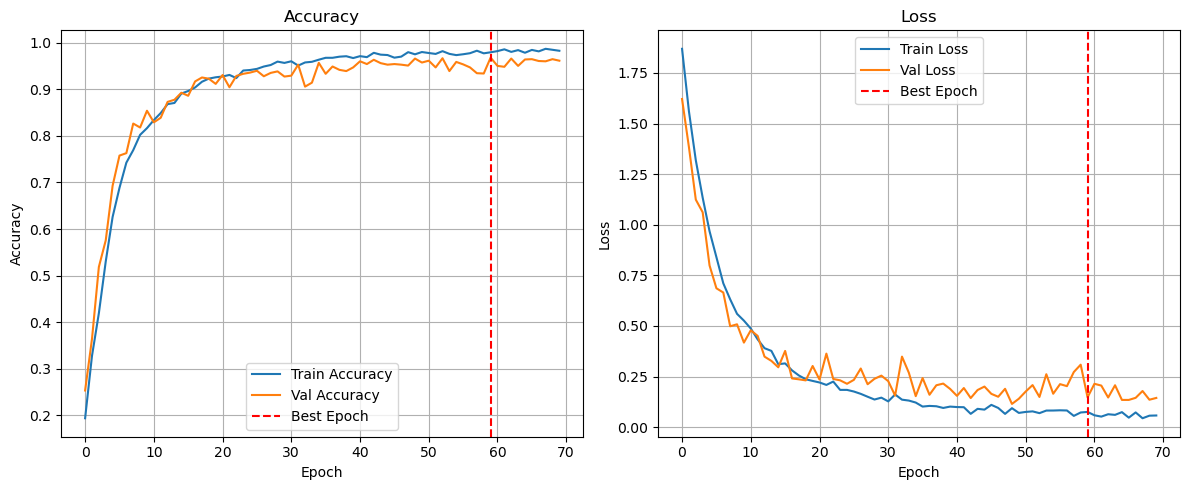

In [21]:
# Grafik akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.axvline(best_epoch-1, color='r', linestyle='--', label='Best Epoch')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Grafik loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axvline(best_epoch-1, color='r', linestyle='--', label='Best Epoch')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [22]:
# Evaluasi

# Predict
start = time.time()
y_pred_probs = model.predict(X_val)
end = time.time()

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val_cat, axis=1)

# WER
ref = [le.classes_[i] for i in y_true]
hyp = [le.classes_[i] for i in y_pred]
wer = jiwer.wer(ref, hyp)

# RTF
audio_duration_total = (X_val.shape[0] * X_val.shape[1]) / 16000  # asumsi 16kHz
rtf = (end - start) / audio_duration_total

# Precision, Recall, F1 Score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Classification report
report = classification_report(y_true, y_pred, target_names=le.classes_)
print("=== Classification Report ===")
print(report)
print(f"Word Error Rate (WER): {wer:.4f}")
print(f"Real Time Factor (RTF): {rtf:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

48/48 [==============================] - 7s 71ms/step
=== Classification Report ===
              precision    recall  f1-score   support

        baca       0.95      0.99      0.97       218
    berhenti       0.99      0.93      0.96       218
        foto       0.99      0.96      0.97       219
        halo       0.97      1.00      0.98       216
        info       0.96      1.00      0.98       217
     kembali       0.95      0.95      0.95       221
       ulang       0.97      0.95      0.96       218

    accuracy                           0.97      1527
   macro avg       0.97      0.97      0.97      1527
weighted avg       0.97      0.97      0.97      1527

Word Error Rate (WER): 0.0321
Real Time Factor (RTF): 0.0804
Precision (weighted): 0.9684
Recall (weighted): 0.9679
F1 Score (weighted): 0.9678


In [23]:
model.save('mymodelc.h5')